In [ ]:
# Imports for the project
import random
import matplotlib.pyplot as plt
import math
from math import comb
from collections import Counter



# ADA511 Course Project: Yahtzee
By: Ole A. Solem & Henrik Vallestad

* We have limited our project to only the **first part of Yahtzee**, where the goal is to get as many of each kind **[1, 2, 3, 4, 5, 6]** and then sum them.
* If the **sum** of [1s, 2s, 3s, 4s, 5s, 6s] is 63, the agent gets a **bonus of 50 points**. 
* Also if the agent gets 5 of a kind, **Yahtzee**, it gets 50 points (which **do not** count on the 63-bonus, but it adds to the total score)
* We run **400 000** games for each scenario, this will give us enough data to accuratly compare them.

We have programmed four different scenarios:

1. **Greedy Algorithm**: Always keeps the highest value.
2. **Strategy with Three of a Kind**: Incorporates a strategy where we try to always get three of a kind and use probability inference to decide whether to keep multiple or discard.
3. **Keep or Discard**: Performs probability inference on possible scenarios of [Keep or discard] for all the dice, and always uses the one that yields the highest probability.
4. **Probability Distribution and Utility Calculation**: Calculates the probability distribution for each of the dice sides, then multiplies the probabilities with its corresponding dice to get the corresponding utility. The algorithm then picks the one that yields the highest utility.

---
### Scenario 1: Greedy Algorithm

Now we implement our first scenario then collect some data to measure a benchmark.
This code mainly consists of two parts:
- Find the most frequent number : `find_most_frequent_available_number()`
- Roll the dice we do not wish to keep : `roll_with_keep()`
- Then we have `oneRound()` which plays out one round of the game: initial roll, find frequent, reroll, frequent, reroll, frequent. The last logic returns our smallest available number in case we try to return something that isn't legal.
- Then we run an entire game, until we have filled all slots.

In [43]:
def find_most_frequent_available_number(dice, available):
    counter = Counter(dice)
    most_common = counter.most_common()
    most_common.sort(key=lambda x: (-x[1], -x[0]))
    
    for num, freq in most_common:
        if num in available:
            return num
    return 0  # Return None if no available number is found


def roll_with_keep(dice, keep):
    new_dice = [d if d == keep else random.randint(1, 6) for d in dice]
    return new_dice


def oneRound(available):
    # Initial roll
    dice = roll_with_keep([1,2,3,4,5], 0)
    keep = find_most_frequent_available_number(dice, available)
    # Second roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)
    # Last roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)

    if keep == 0:
        keep= available[0]

    return dice, keep

In [50]:
# ONE_ROUND 1
available = [1, 2, 3, 4, 5, 6]
totalSum = 0
simTimes = 400000
for _ in range(simTimes):
    dice, keep = oneRound(available)
    totalSum += dice.count(keep)*keep
print(totalSum/simTimes)

12.423605


In [23]:
#Run time with repeat=400000 : ~ 15 sec
repeat = 400000
round_one_score = 0
game_score = 0
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0

# Game Simulation
for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    score = 0
    yahtzee = False
    while(len(available) > 0):
        dice, keep = oneRound(available)
        s = dice.count(keep)*keep
        if(dice.count(keep) == 5) and not yahtzee:
            yahtzee = True
            game_score += 50
            times_yahtzee += 1
        else:
            available.remove(keep)
            score += s
    round_one_score += score
    game_score += score
    
    if (yahtzee) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1


AVG score after 400000 games : 56.393565
Times player got yahtzee : 69597
Times player got yahtzee and over 63 : 17667

Percentage of games :: Score over 63 : 22.0%
percentage of games :: yahtzee : 17.4%
percentage of games :: yahtzee and score over 63 : 4.3999999999999995%


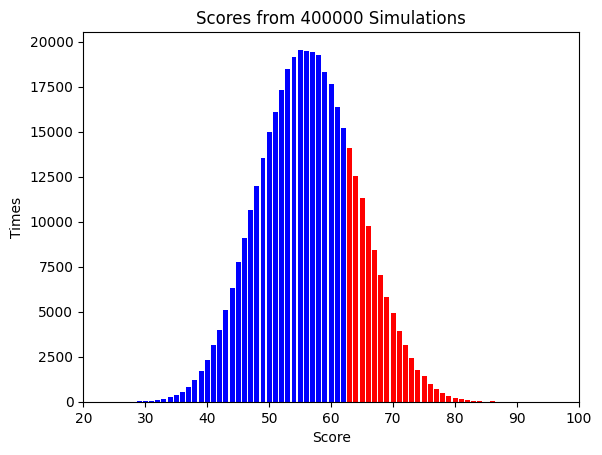

In [24]:
# Benchmark from our programmed inference and decision

print(f"AVG score after {repeat} games : {round_one_score/repeat}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()

### Scenario 2: Strategy with Three of a Kind

The thought behind this is that in order to get the **63-bonus worth 50 points**, we want to get an **average of three dice of each kind**.

* We start out with an initial inference on the dice to get the probabilities of "three of a kind" and "probability of Yahtzee". 
* In our inference we also give a huge bonus for dice that is 3 or above, since they already are 3x
* However, we penalize the number 1 because in the end it doesn't really contribute all that much to the final score.
* For example if we roll 1,1,1,6,6 : then 6,6 is higher rated

Then we do a `KeepDiceDecision()` which gives us the number of different dice we should keep. It does this by doing an inference on the different probabilities when keeping multiple dice `keepMultipleInference()`. We do this until we reach our final decision, `endTurnDecision()`, where we do a greedy inference if we didn't get a clear decision. Also, if we decided to keep 4, 5, or 6 but we didn't have three or more of them, we can set our 1-spot to zero instead of wasting our "good spots" on a bad score. This can only be done once.


In [30]:
def inference_partOne(dice, available):
    
    p_outcome = 1/6
    p_not_outcome = 1-p_outcome
    
    #Dictionary of the choices and their given score at the end
    prob_dict = {}

    for d in set(dice):
        #only do inference if the dice has not been alreay used
        if (d in available):
            # How many of a kind
            count = dice.count(d)

            # Probability of a yahtzee our next turn.
            ytzy_prob = math.pow(p_outcome, 5-count)
            
            # probability that somethings gets 3 of a kind. Heavily benefits if its over, even though its still just 100% likely.
            beat3x_prob = math.pow(p_outcome,(3-count))
            
            # Overall score calculated on the probabilities and dice
            ovral_score = (ytzy_prob+beat3x_prob)
            
            # Reduce the weight of the overall score for number 1,
            # by 1/3
            if (d == 1):
                ovral_score = ovral_score*(1-1/3)
                
            # Round of because we dont care about super small variations in probability
            prob_dict[d] = round(ovral_score, 6)
        else:
            prob_dict[d] = 0

    return prob_dict

def probabilityThreeOfAKind(dice, similar):
    # Probability of rolling a specific number on a die
    p_outcome = len(similar) / 6
    n_p_outcome = 1-p_outcome

    # Number of dice with the same face as the first "similar" value
    target_count = dice.count(similar[0])

    # n = number of dice we're rolling
    # k = number of additional dice needed to match the value we're aiming for
    n = len(dice)-target_count
    k = 3-target_count

    results = (comb(n, k))*(p_outcome**k)*(n_p_outcome**(n-k))


    return results

def keepMutipleInference(dice, similar):
#Dictionary of the choices and their given score at the end
    p_outcome = 1/6
    keep_dict = {}
    count = dice.count(similar[0])
    
    for i in range(len(similar)):
        index = i+1
        p_ytze = 0
        p_3x = 0
        dice_to_roll = 5-(count*index)
        
        #Its only possible with yahtzee if we keep 1 kind.
        if (index == 1):
            p_ytze = math.pow(p_outcome, 5-count)

        p_3x = probabilityThreeOfAKind(dice, similar[:index])
        
        ovral = p_ytze + p_3x

        keep_dict[index] = round(ovral, 6)

    return keep_dict


# Returns the number of (amount) different dice we should keep. Not the specific type of dice. 
def keepDiceDecision(dice, available, prob_dict):
    
    # By default we keep one dice
    keepDice = [0]
    
    # Find highest probabilities, can be multiple 
    high_die = max(prob_dict, key=prob_dict.get)
    same_value_dice = [key for key, value in prob_dict.items() if value == prob_dict[high_die]]
    
    
    # Use keepMultipleInference to check how many dice we should keep
    if len(same_value_dice) > 1:
        keepMultiple = keepMutipleInference(dice, same_value_dice)
        keepDice = max(keepMultiple, key=keepMultiple.get)

        same_value_dice.sort(reverse=True)
        keepDice = same_value_dice[:keepDice]
    else:
        keepDice = [high_die]

    return keepDice

def keepDice(dice, prob_dict, available):
    
    # If we didnt roll any available dice, reroll all dice
    if not any(key in available for key in prob_dict.keys()):
        return [0]

    return keepDiceDecision(dice, available, prob_dict)


def rollDice():
    return sorted([random.randint(1, 6) for _ in range(5)])

def rollDiceKeepType(dice, keep):
    copy = dice.copy()
    for i in range(len(dice)):
        if (not dice[i] in keep):
            copy[i] = random.randint(1,6)
    
    return sorted(copy)

def endTurnDecision(dice, kept, available):

    # If we didnt get anything good on our last throw we should do some basic inference
    if kept[0] == 0:

        prob_dict = inference_partOne(dice, available)
        kpt = keepDice(dice, prob_dict, available)
        
        if kpt[0] == 0:
            return available[0]
        else:
            kept = kpt
            
    
    amount = dice.count(kept[0])
    
    # if we have a 4, 5 or 6 which is less than 3 and we have a spare 1 available, use the one as extra life.
    if (amount < 3) and any(x in kept for x in [4, 5, 6]) and (1 in available):
        return available[0]
    
    return kept[-1]


def oneGameSim(dice, available):

    kept = []
    #Test specific dice combination
    #dice = [1,1,1,4,4]
    turn = 2
    for i in range (turn):
        # Calculate probability for high scores
        prob_dict = inference_partOne(dice, available)
        # Get the one that is kept based on prob_dict
        kept = keepDice(dice, prob_dict, available)
        dice = rollDiceKeepType(dice, kept)
        
    
    eTD = endTurnDecision(dice, kept, available)
    count = dice.count(eTD)
    score = count*eTD


    return (score, eTD)    



In [52]:
# ONE_ROUND 2
totalSum = 0
simTimes = 400000
for _ in range(simTimes):
    s, k = oneGameSim(rollDice(), [1,2,3,4,5,6])
    totalSum += s
print(totalSum/simTimes)

8.48077


In [ ]:
#Run time with repeat=400000 : ~20 sec
repeat = 400000
round_one_score = 0
game_score = 0
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0

# Game Simulation
for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    score = 0
    yahtzee = False
    while(len(available) > 0):
        dice = rollDice()
        s, k = oneGameSim(dice, available)
        if(s/k == 5) and not yahtzee:
            yahtzee = True
            game_score += 50
            times_yahtzee += 1
        else:
            available.remove(k)
            score += s
    round_one_score += score
    game_score += score
    
    if (yahtzee) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1

AVG score after 400000 games : 54.714215
Times player got yahtzee : 64369
Times player got yahtzee and over 63 : 15209

Percentage of games :: Score over 63 : 20.0%
percentage of games :: yahtzee : 16.1%
percentage of games :: yahtzee and score over 63 : 3.8%


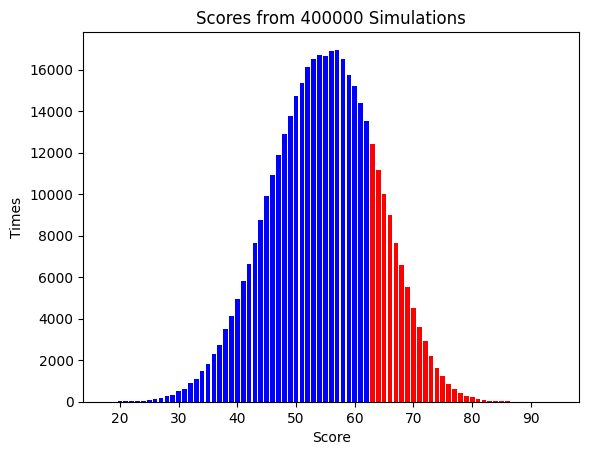

In [ ]:
# Benchmark from our programmed inference and decision

print(f"AVG score after {repeat} games : {round_one_score/repeat}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()

### Scenario 3: Keep or Discard

The idea with this scenario is to do inference and decision on the sum of the probabilities of n-of a kind (n is from 1 to 5). 

There's no special strategy coded, however, we infer **keep or discard** for every dice. 

For example: if we have only two dice, then we do inference for [d,d], [d,k], [k,d], [k,k].
  K is always keep, d is always discard with no exception.
  
  Number of inferences is 2^number_of_dice 


The one that yields the highest outcome should be further used. We then continue our game where we keep [k] and re-roll [d]. 

If we reach the end of the turn with two of equal score, say dice = [2, 2, 3, 3, 1], then we keep the lowest ones [2, 2].

In [54]:
# Gives every 0 or 1 (discard or keep) combination for the number of dice we trow.
def dynamic_loop(depth, current_depth=0, current_combination=[], result=None):
    global i
    if result is None:
        result = {}
        i = 0
    
    if current_depth == depth:
        result[i] = current_combination
        i += 1
        return result
    
    #Keep or discard: Where 0 is discard and 1 is keep
    
    for value in [0,1]:
        dynamic_loop(depth, current_depth + 1, current_combination + [value], result)
    
    return result


# Function for removing non-available dice (and keepList position)
def getAllAvailableDice(dice, keepList, available):
    
    diceCopy = dice.copy()
    keepListCopy = keepList.copy()

    # Collect indices to remove, we only want to remove if we wish to keep the dice
    indices_to_remove = []
    for i, d in enumerate(dice):
        if d not in available and keepList[i] == 1:
            indices_to_remove.append(i)
            
    # Remove in reverse order, (preserve the indexes)
    for i in sorted(indices_to_remove, reverse=True):
        del diceCopy[i]
        del keepListCopy[i]
    
    return diceCopy, keepListCopy

def xOfAKind(x, keepList, dice):

    #Return 0 if theres less dice available to us, than what we want.
    if len(dice) < x:
        return [0], 0.0
    
    # If a number in keepList is 1, we keep otherwise we HAVE to throw it.
    # Count all number we keep and throw.
    keepDict = {}
    unique = 0
    keepAmount = 0
    throwAmout = 0
    
    for i, keep in enumerate(keepList):
        if keep == 0:
            throwAmout += 1
        else:
            keepAmount += 1
            if dice[i] in keepDict:
                keepDict[dice[i]] += 1
            else:
                keepDict[dice[i]] = 1
                unique += 1

    # Check the keepDict for highest x of a kind.
    tmpK = 0
    for key, value in keepDict.items():
        if value >= x:
            if key > tmpK:
                tmpK = key
    if tmpK != 0: 
        return [tmpK], 1.0
    
    # In case we dont want to keep any dice, for example keepDice = [0,0,0]
    # Return all options and the chance of x of a kind.
    if unique == 0:
        return available, ((1/6)**x)

    # Probability of rolling a specific number on a die
    p_outcome = unique / 6
    n_p_outcome = 1-p_outcome

    # n = number of dice we're rolling
    # k = number of additional dice needed to match the value we're aiming for
    n = throwAmout
    k = int(x-(keepAmount/unique))

    results = (comb(n, k))*(p_outcome**k)*(n_p_outcome**(n-k))

    keys = list(keepDict.keys())

    return keys, results

# Calculating the probability of getting num, given that we're keeping the numbers in keepList
def inference(keepList, dice, available):
    inf = 0
    di = 0
    
    diceCopy, keepListCopy = getAllAvailableDice(dice, keepList, available)
    
    # Calculate Chance of 1 of a kind, 2 of a kind ... n of a kind and add to inf
    for i in range(1,len(dice)+1):
        d, p = xOfAKind(i, keepListCopy, diceCopy)
        
        # take the average of the numbers returned times with the probability times the number of similar. 
        score = p
        
        # add the score to the total inference
        inf += score 
        
    return inf, keepList, dice

# Reroll all dice that we do not want to keep.
def reroll(dice, keepList):
    diceC = dice.copy()
    for i in range(len(keepList)):
        if keepList[i] == 0:
            diceC[i] = random.randint(1, 6)

    return diceC


from collections import Counter

# Do a starting roll -> the first inference and decision -> the second inference and decision
# Return the dice we kept, and how many we got.

def oneRound(numberOfDice, available):
    # A dict of all combinations
    combinations_dict = dynamic_loop(numberOfDice)
    dice = []
    keepDice = 0
    keepList = []
    topInf = 0

    # Initial roll, roll all num of dice
    for _ in range(numberOfDice):
        dice.append(random.randint(1, 6))
    

    # Custom dice for testing purposes.
    # dice = [2, 2, 2, 2, 5]

    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    
    
    dice = reroll(dice, keepList)


    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    dice = reroll(dice, keepList)

    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    
    # We have no choice but to keep all this stage.
    diceCopy, keepListCopy = getAllAvailableDice(d, [1,1,1,1,1], available)

    # We might not have rolled any available dice, so we should check for this.
    # If this is the case, return the first element in the available list.
    if not diceCopy:
        return available[0], 0

    # Return the most occuring dice
    counter = Counter(diceCopy)
    maxOccuringDice, amount = counter.most_common(1)[0]

    return maxOccuringDice, amount


In [56]:
# ONE_ROUND 3 
totalSum = 0
simTimes = 400000
for _ in range(simTimes):
    kept, amount = oneRound(5, [1,2,3,4,5,6])
    totalSum += kept*amount
print(totalSum/simTimes)

10.0789875


In [ ]:
# Run time with repeat=400000 : ~ 12.5 min
numberOfDice = 5
repeat = 400000
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0
totalScore = 0

for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    ytzi = False
    score = 0
    for i in range(6):
        kept, amount = oneRound(numberOfDice, available)
        if (amount == numberOfDice) and not ytzi:
            ytzi = True
            times_yahtzee += 1
        else:
            available.remove(kept)
            score += kept*amount

    totalScore += score

    if (ytzi) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1

AVG score after 400000 games : 53.1005075
Times player got yahtzee : 54083
Times player got yahtzee and over 63 : 2399

Percentage of games :: Score over 63 : 13.0%
percentage of games :: yahtzee : 13.5%
percentage of games :: yahtzee and score over 63 : 0.6%


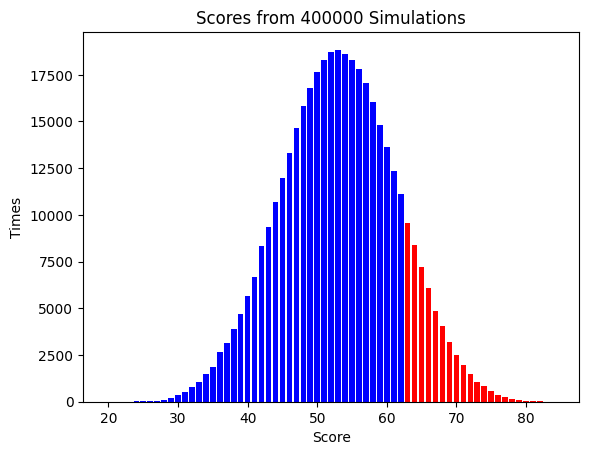

In [ ]:
# Benchmark from our decision tree inference and decision

print(f"AVG score after {repeat} games : {totalScore/repeat}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()


Scenario 4: Probability Distribution and Utility Calculation

This implementation calculates the probability distribution for each dice side and determines the expected utility by multiplying these probabilities with their respective dice values, summing the results to derive the overall utility. The algorithm then identifies and selects the option that provides the maximum utility.

The function cumulative_probability_distribution_for_dice_set computes the probability of rolling between 0 and N occurrences of each dice side, considering the remaining turns and the number of dice rolled. Using this distribution, the algorithm evaluates which dice contribute the most to the overall utility. Dice with the highest utility are kept, while others are rerolled to increase the likelihood of a better outcome. In the final step, the algorithm selects the configuration that maximizes the overall utility.

For example, during the first turn of a game, a roll might yield the dice values [5, 2, 5, 3, 6], resulting in a count of [0, 1, 1, 0, 2, 1] for each side. The expected utilities for these sides are calculated as [2.11, 5.37, 8.06, 8.42, 16.31, 16.11], leading to the decision to retain the dice with a value of 5. 


In [2]:


def binomial_probability(n, k, p):
    """Calculate binomial probability of getting exactly k successes in n trials"""
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))
def cumulative_probability_distribution_for_dice_set(n_turns=3, rolled_dice=1, ):
    p = 1 / 6 
    
   
    current_distribution = [0] * (rolled_dice + 1)
    current_distribution[0] = 1.0  
    for turn in range(n_turns):
        next_distribution = [0] * (rolled_dice + 1)
        
        for current_ones in range(rolled_dice + 1):
            remaining_dice = rolled_dice - current_ones
            for new_ones in range(remaining_dice + 1):
                prob_new_ones = binomial_probability(remaining_dice, new_ones, p)
                next_distribution[current_ones + new_ones] += current_distribution[current_ones] * prob_new_ones
                
        current_distribution = next_distribution
    current_distribution = [round(prob, 4) for prob in current_distribution]
    return current_distribution


In [ ]:

class YahtzeeSection:
    def __init__(self, name, is_set, score, number):
        self.name = name
        self.is_set = is_set
        self.score = score
        self.number = number
class Game:
    def __init__(self):
        self.dice_set = [0, 0, 0, 0, 0]
        self.locked_dice = [False, False, False, False, False]
        self.sections = [
            YahtzeeSection("Ones", False, 0, 1),
            YahtzeeSection("Twos", False, 0, 2),
            YahtzeeSection("Threes", False, 0, 3),
            YahtzeeSection("Fours", False, 0, 4),
            YahtzeeSection("Fives", False, 0, 5),
            YahtzeeSection("Sixes", False, 0, 6),
        ]
        self.total_rounds = 6
        self.total_score = 0
        self.total_turns_in_a_round = 3 
    def roll_all_dice(self):
        for i in range(5):
            if self.locked_dice[i] == False:
                self.dice_set[i] = random.randint(1, 6)

    def calculate_score(self):
        for section in self.sections:
            self.total_score += section.score
            
    def make_decision_greedy(self, expected_utilities, turn):
        for section in self.sections:
            if section.is_set == True:
                expected_utilities[section.number - 1] = 0
        
        max_utility = max(expected_utilities)
        max_utility_index = expected_utilities.index(max_utility)
        
        return max_utility_index
       
     

    def play_round(self):
        remaining_turns = self.total_turns_in_a_round 
        for turn in range(self.total_turns_in_a_round):
            remaining_turns = remaining_turns - turn
            
            self.roll_all_dice()
            
          
            dice_count = []
            expected_utilities = []
            for dice_value in range(6):
                dice_count.append(self.dice_set.count(dice_value + 1))
                simulated_rolled_dice = 5 - dice_count[dice_value]
                distribution = cumulative_probability_distribution_for_dice_set(n_turns=self.total_turns_in_a_round - turn, rolled_dice=simulated_rolled_dice)
                
                expected_utility = 0
                for k, prob in enumerate(distribution):
                    expected_utility += (k + dice_count[dice_value]) * prob * (dice_value + 1)
                
                expected_utilities.append(expected_utility)
            
            kept_dice = self.make_decision_greedy(expected_utilities, turn) + 1
            
            
            
            for i in range(len(self.dice_set)):
                if self.dice_set[i] == kept_dice:
                    self.locked_dice[i] = True
                else:
                    self.locked_dice[i] = False
 
        products = []
        for i in range (6):
          
            prod = dice_count[i] * (i + 1)
            if self.sections[i].is_set == True:
                prod = 0
            products.append(prod) 

         
        maximum = max(products)
        maximum_index = products.index(maximum)
        self.sections[maximum_index].is_set = True
        self.sections[maximum_index].score = maximum
     

    def play_game(self):
        for i in range(self.total_rounds):
            self.play_round()
        self.calculate_score()
   
            


In [62]:
# ONE_ROUND 4
totalSum = 0
simTimes = 400000
for _ in range(simTimes):
    game = Game()
    game.play_round()
    game.calculate_score()
    totalSum += game.total_score
print(totalSum/simTimes)

14.715505


In [5]:
# Simulation
num_simulations = 400000
total_scores = []
num_yahztees = 0
num_yahztees_and_63_PDAU = 0
for _ in range(num_simulations):
    game = Game()
    game.play_game()
    total_scores.append(game.total_score)
    for section in game.sections:
        
        if section.score/section.number == 5:
            num_yahztees += 1
            if game.total_score >= 63:
                num_yahztees_and_63_PDAU += 1
            

# Analyze results
average_score = sum(total_scores) / num_simulations
print(f"Average score over {num_simulations} games: {average_score}")
print(f"Number of Yahtztees: {num_yahztees}")
for section in game.sections:
    print(f"{section.name}: {section.score}")
print(f"Number of Yahtztees and score over 63: {num_yahztees_and_63_PDAU}")

Average score over 400000 games: 49.4735175
Number of Yahtztees: 30544
Ones: 0
Twos: 4
Threes: 3
Fours: 4
Fives: 20
Sixes: 12
Number of Yahtztees and score over 63: 9600


Average score over 400000 games: 49.4735175
Percentage of games :: Score over 63 : 6.0%
percentage of games :: yahtzee : 7.6%
Percentage of games with score over 63: 2.4%


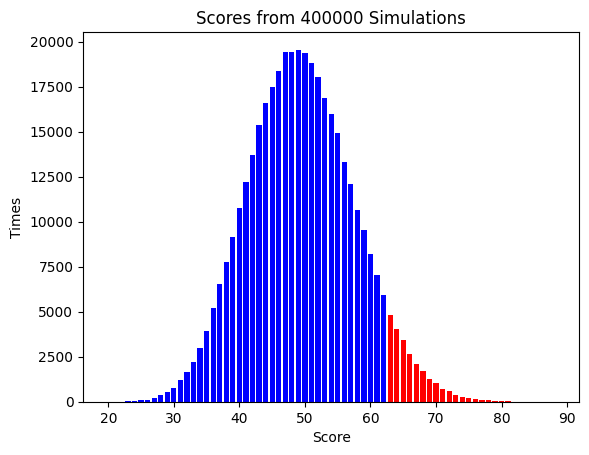

In [6]:



average_score = sum(total_scores) / num_simulations


score_counts = Counter(total_scores)
larger_than_63 = [score for score in total_scores if score >= 63]
percentage_larger_than_63 = len(larger_than_63) / num_simulations * 100
scores = list(score_counts.keys())
frequencies = list(score_counts.values())
colors = ['red' if score >= 63 else 'blue' for score in scores]

print(f"Average score over {num_simulations} games: {average_score}")
print(f"Percentage of games :: Score over 63 : {round( len((larger_than_63 ))/num_simulations ,2)*100}%")
print(f"percentage of games :: yahtzee : {round((num_yahztees/num_simulations),3)*100}%")
print(f"Percentage of games with score over 63: {round(num_yahztees_and_63_PDAU / num_simulations * 100, 3)}%")

plt.bar(scores, frequencies, color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {num_simulations} Simulations')
plt.show()






## Conclusion

We can see that the greedy algorithm is the most effective algorithm, with the highest average score of 56.39 and with the largest proportion of games resulting in Yahtzee and a score of over 63. These results highlight that a simpler greedy algorithm can often outperform more advanced algorithms. Greedy algorithms typically yield reasonable results in the short term but fail to take into account the future aspects of the game.  The same can be said for the Probability Distribution and Utility algorithm, this algorithm maximizes the average score for each round played. This, however, does not work in the long term, and acts as an example of how greedy algorithms can get stuck in local minima, unable to achieve a globally optimal result.  To achieve the highest possible end-game score, a more advanced algorithm is required. One that considers not only the immediate payoffs, but also the cascading effect of decisions affecting future rounds. 

| Algorithm                          | Avg Score | % Games Yahtzee | % Score >= 63 | Yahtzee and 63 |
|------------------------------------|-----------|-----------------|---------------|----------------|
| Greedy                             | 56.39     | 17.4 %          | 22 %          | 4.39 %         |
| 3 of Strat                         | 54.71     | 16.1 %          | 20 %          | 3.8 %          |
| Keep Or Discard                    | 53.10     | 13.5 %          | 13 %          | 0.6 %          |
| Probability Distribution and Utility | 49.46   | 7.6 %           | 5.93 %        | 2.4 %          |

---

| Algorithm      | Single Round avg Score |
|----------------|-------------------------|
| Greedy         | 12.42                  |
| 3 of Strat     | 8.48                   |
| Keep Or Discard| 10.07                  |
| PD & U         | 14.71                  |
